In [5]:
# Improved genetic algorithm
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
# from arctic import Arctic
import os
from scipy.stats import entropy as sc_entropy
import scipy as sc
from tqdm import tqdm
import yfinance as yf

NameError: name 'mean' is not defined

In [7]:
def build_sector_environment(depth=600, scale=252, window=None):
    environment = pd.DataFrame()
    for sector in sector_list:
        environment[sector] = sector_lib.read(sector).data.log_ret
    environment.dropna(inplace=True)
    environment = environment.tail(depth)
    if window is None:
        return scale*environment.mean(), scale*environment.cov()
    else:
        means = [environment[i:i+window].mean()*scale for i in range(0,environment.shape[0],window)]
        covs = [environment[i:i+window].cov()*scale for i in range(0,environment.shape[0],window)]
        return np.array(means), np.array(covs)

class Asset():
    def __init__(self, ticker="SPY", backtest_period='5y', time_scale=1, sector=None, asset_type=None):
        self.ticker = self.symbol = ticker
        _ = yf.Ticker(ticker)
        self.time_scale = time_scale
        self.data = _.history(period=backtest_period)
        self.index = self.data.index
        self.meta = {'sector': sector, 'type': asset_type}
    def __repr__(self):
        return f"{self.ticker}: {round(self.close[-1],3)}; {self.meta}"
    @property
    def close(self):
        return self.data.Close
    @property
    def log_returns(self):
        _log_returns = np.log(self.close/self.close.shift(self.time_scale))
        return _log_returns.dropna()
    @property
    def returns(self):
        return self.log_returns.apply(self.expm1)
    @staticmethod
    def expm1(vec):
        return np.exp(vec)-1
    @property
    def normalized_price(self):
        return self.log_returns.cumsum().apply(self.expm1)

etf_universe = {"energy":["VDE", "USO", "XES", "XOP", "UNG", "ICLN", "ERX", "UCO", "AMJ", "BNO", "AMLP", "UGAZ", "TAN"],
               "metals": ["GLD", "IAU", "SLV", "GDX", "AGQ", "PPLT", "NUGT", "USLV", "JNUG" ,"DUST", "JDST"],
               "tech":["QQQ", "IGV", "QTEC", "FDN", "FXL", "TECL", "SOXL", "SKYY", "KWEB", "TECS", "SOXS"],
                "spy":["XLB", "XLE", "XLF", "XLI", "XLK", "XLP", "XLU", "XLV", "XLY"]}
                
    
def build_universe(universe ,depth, scale=252):
    portfolio = pd.DataFrame()
    for sector, etf_list in tqdm(universe.items()):
        for etf in etf_list:
            _  = Asset(etf, backtest_period='5y', asset_type="etf", sector=sector) # space inefficient
            portfolio[etf] = _.log_returns.tail(depth)
    return scale*portfolio.mean(), scale*portfolio.cov()

In [8]:
mean, cov = build_universe(etf_universe, 100)

100%|██████████| 4/4 [00:14<00:00,  3.70s/it]


In [19]:
GENOME_LENGTH = len(mean)


class Cell:
    def __init__(self, genome=None, generation=0, mutation_factor=0.05):
        self.generation = generation
        self.mutation_factor = mutation_factor
        if not self.generation: # random genome
            self.genome = np.random.rand(GENOME_LENGTH)
            self.fitness = 0
            self.generation = generation
        else:
            self.genome = genome
        self.alive = 1
    @property
    def weights(self):
        return self.genome/np.sum(self.genome)
    def update_genome(self):
        new_genome = self.genome + np.round(self.mutation_factor * np.random.randint(-GENOME_MAX,GENOME_MAX, size=GENOME_LENGTH))
        return np.where(np.sign(new_genome)==1, new_genome, 0)
    def mate(self, cell):
        return Cell(genome=np.convolve(self.genome, cell.genome), generation=self.generation+1, mutation_factor=self.mutation_factor)
    def __repr__(self):
        return f'Genome: {str(np.round(self.genome,3) )}, Generation: {self.generation}'

In [21]:
print(Cell().mate(Cell()))

Genome: [ 0.034  0.04   0.652  1.355  1.558  1.881  1.917  1.568  1.99   2.453
  2.396  2.304  3.181  3.794  3.667  3.956  4.684  5.193  5.539  5.836
  6.26   7.148  7.335  7.9    7.748  7.943  7.396  6.577  6.997  8.469
  8.572  8.665  9.105 10.518 10.783 11.652 11.516 11.422 11.68  11.359
 11.739 11.515 12.352 12.561 11.469 11.221 10.635 10.055 10.868 10.807
 10.805  9.571  9.944 10.191  9.351  9.663  9.249  7.827  7.497  7.621
  7.77   7.418  6.626  6.694  5.529  5.405  5.323  4.175  4.145  4.188
  3.657  3.39   3.51   3.239  3.012  2.857  2.319  1.236  1.644  1.739
  1.26   0.881  0.679  0.532  0.353  0.739  0.325], Generation: 1


In [22]:
class Colony:
    def __init__(self):
        self.members = []
        self.data = []
        self.size = 0
        self.total_fitness = 0
    def append(self, cell):
        self.members.append(cell)
        self.data.append(cell.genome)
        self.size += 1
        self.total_fitness += cell.fitness
        self.length = np.count_nonzero(cell.weights)
    @property
    def average_length(self):
        return self.length/self.size
    @property
    def average_fitness(self):
        if self.size:
            return self.total_fitness/self.size
        else:
            return  0
    @property
    def entropy(self):
        # Compute the entropy of the entropy of each element of the genome across the colony
        return (sc_entropy(self.data, axis=0))

In [24]:
def sharpe(w, cov, mean, benchmark_rate=0):
    std = np.sqrt(w.T.dot(cov).dot(w))
    mean_return = mean.dot(w)
    return (mean_return-benchmark_rate)/std

def first_gen(num_cells, mean, cov):
    colony = Colony()
    for _ in range(num_cells):
        cell = Cell(generation=0)
        cell.fitness = sharpe(cell.weights, cov, mean)
        colony.append(cell)
    return colony
sample_colony = first_gen(400, mean, cov)

In [25]:
index_sharpe = 0.9
colonies = [first_gen(100, mean, cov)]
p = 0.3
dp = 0
log = {"entropy": [], "fitness": [], "size":[]}
for gen_idx in tqdm(range(0, 300)):
    new_colony = Colony()
    for i, cell in enumerate(colonies[gen_idx].members):
        if  cell.fitness > colonies[gen_idx].average_fitness or np.random.rand()<p-dp*2.:
            for _ in range(0, np.random.randint(1, 3)):
                cell.mate(colonies[gen_idx].members[i+1])
                cell.fitness = sharpe(cell.weights, cov, mean)
                new_colony.append(cell)
        else:
            pass
    if gen_idx>1:
        dp = (new_colony.size-colonies[-2].size)/new_colony.size
    else:
        dp = 0
    colonies.append(new_colony)
    log["entropy"].append(new_colony.entropy/new_colony.size)
    log["fitness"].append(new_colony.average_fitness/index_sharpe)
    log["size"].append(new_colony.size)
    if new_colony.size<2:
        break

100%|██████████| 300/300 [00:01<00:00, 209.52it/s]


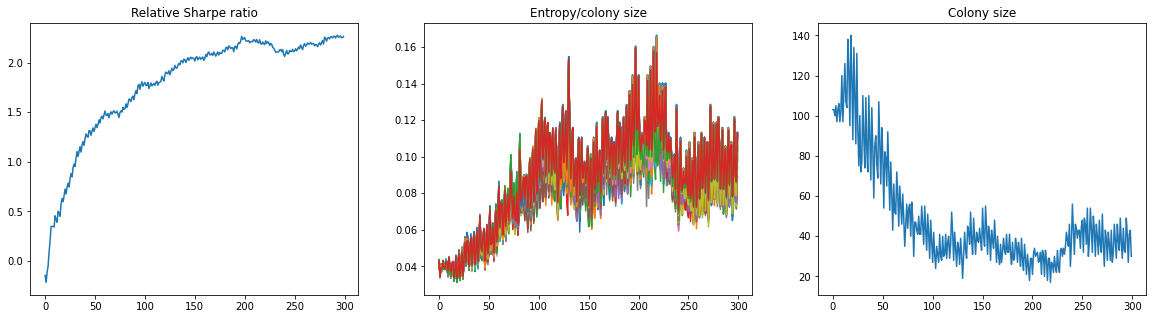

In [26]:
def plot_simulation(log):
    fig, ax = plt.subplots(1, 3, figsize=(20,5))
    ax[0].plot(log["fitness"]);
    ax[0].set_title("Relative Sharpe ratio");
    ax[1].plot(log['entropy']);
    ax[1].set_title("Entropy/colony size");
    ax[2].plot(log['size']);
    ax[2].set_title("Colony size");
plot_simulation(log)